# Assignment: Optimization, Convex Geometry, and Channel Pruning

#### Reporter: Denis Boborukhin, Skoltech, 2025  

### Core setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use only three classes
CLASSES_TO_USE = [0, 1, 2]
K = len(CLASSES_TO_USE)

def get_filtered_subset(dataset, num_samples_per_class=1000):
    indices = []
    label_map = {original_label: new_label for new_label, original_label in enumerate(CLASSES_TO_USE)}
    dataset.targets = torch.tensor(dataset.targets)

    for original_label in CLASSES_TO_USE:
        class_indices = torch.where(dataset.targets == original_label)[0]
        indices.extend(class_indices[:num_samples_per_class].tolist())
        for idx in class_indices[:num_samples_per_class]:
            dataset.targets[idx] = label_map[original_label]

    return Subset(dataset, indices)

train_subset = get_filtered_subset(full_trainset, num_samples_per_class=1000)
test_subset = get_filtered_subset(full_testset, num_samples_per_class=300)

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
testloader = DataLoader(test_subset, batch_size=64, shuffle=False)

print(f"Using device: {device}")
print(f"Simplified dataset created with {len(train_subset)} training images and {len(test_subset)} test images for {K} classes.")

# load pretrained backbone
resnet_backbone = nn.Sequential(*list(resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).children())[:-2])
resnet_backbone.eval()
resnet_backbone.to(device)
for param in resnet_backbone.parameters():
    param.requires_grad = False

with torch.no_grad():
    dummy_output = resnet_backbone(torch.randn(1, 3, 224, 224).to(device))
    C_out, H, W = dummy_output.shape[1:]

100%|██████████| 170M/170M [00:04<00:00, 40.3MB/s]


Using device: cuda
Simplified dataset created with 3000 training images and 900 test images for 3 classes.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


# Task 1: Sparse channel selection

Consider a convolutional layer in ResNet-18 with output tensor  
$ X \in \mathbb{R}^{B \times C_{\text{out}} \times H \times W} $,  
where $ B $ is the batch size, $ C_{\text{out}} $ the number of output channels, and $ H \times W $ the spatial size.  

For each sample $ b $, flatten the spatial dimensions so that  
$ X_b \in \mathbb{R}^{C_{\text{out}} \times HW} $.  

Introduce a channel weight vector $ w \in \mathbb{R}^{C_{\text{out}}} $ and a spatial-to-class mapping matrix $ F \in \mathbb{R}^{HW \times K} $, where $ K $ is the number of classes. The class score for sample $ b $ is defined as  
$ s_b = w^\top X_b F \in \mathbb{R}^K $.  

Train only $ w $ and $ F $ (keeping the backbone frozen) by solving  
$$
\min_{w,F} \frac{1}{B} \sum_{b=1}^B \ell(s_b, y_b) + \lambda \|w\|_1 + \gamma \|F\|_F^2,
$$  
where $ \ell $ is the cross-entropy loss and $ y_b $ is the one-hot label.  


### Model and Evaluation Utilities

In [2]:
class ChannelSelectionModel(nn.Module):
    def __init__(self, backbone, C_out, H, W, K):
        super().__init__()
        self.backbone = backbone

        self.w = nn.Parameter(torch.randn(C_out) * 0.01)
        self.F = nn.Parameter(torch.randn(H * W, K) * 0.01)
        self.logit_scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        with torch.no_grad():
            X = self.backbone(x)

        w_norm = torch.norm(self.w, p=2, dim=0, keepdim=True)
        w_normalized = self.w / (w_norm + 1e-8)

        X_flat = X.view(X.shape[0], C_out, H * W)

        w_T_X = torch.einsum('c, bci -> bi', w_normalized, X_flat)
        scores = torch.matmul(w_T_X, self.F) * self.logit_scale
        return scores

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

### (a) Report classification accuracy before and after pruning

#### Training the baseline model (no sparsity)

In [ ]:
lr_base = 1e-3
total_epochs_base = 5
baseline_model = nn.Sequential(
    resnet_backbone, nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(C_out, K)
).to(device)
optimizer_base = optim.Adam(baseline_model[-1].parameters(), lr=lr_base)
criterion = nn.CrossEntropyLoss()
for epoch in range(total_epochs_base):
    baseline_model.train()
    progress_bar = tqdm(trainloader, desc=f"Baseline Epoch {epoch+1}", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_base.zero_grad()
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_base.step()
accuracy_before = evaluate_model(baseline_model, testloader)
print(f"\nAccuracy BEFORE Pruning (Baseline): {accuracy_before:.2f}%\n")


Baseline Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

Baseline Epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

Baseline Epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

Baseline Epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

Baseline Epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]


Accuracy BEFORE Pruning (Baseline): 92.67%



#### Training the sparse model

In [ ]:
lr = 1e-4
total_epochs = 15
final_lambda = 0.1
gamma_val = 0.001
pruning_threshold = 1e-4

sparse_model = ChannelSelectionModel(resnet_backbone, C_out, H, W, K).to(device)
optimizer = optim.Adam(sparse_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(total_epochs):
    sparse_model.train()
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = sparse_model(inputs)
        ce_loss = criterion(outputs, labels)
        l1_penalty = final_lambda * torch.norm(sparse_model.w, 1)
        l2_penalty = gamma_val * torch.norm(sparse_model.F, 'fro')**2
        loss = ce_loss + l1_penalty + l2_penalty
        loss.backward()
        optimizer.step()

final_weights = sparse_model.w.detach().clone()
pruned_w = final_weights.clone()
pruned_w[torch.abs(pruned_w) < pruning_threshold] = 0
sparse_model.w.data = pruned_w
accuracy_after = evaluate_model(sparse_model, testloader)
num_retained = torch.sum(torch.abs(final_weights) > pruning_threshold).item()
sparsity_pct = (C_out - num_retained) / C_out * 100
print(f"Accuracy AFTER Pruning (λ={final_lambda}): {accuracy_after:.2f}% with {sparsity_pct:.2f}% sparsity\n")

Epoch 1/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/47 [00:00<?, ?it/s]

Accuracy AFTER Pruning (λ=0.1): 85.44% with 16.41% sparsity



The "before" accuracy achieves high value (>90%), proving that the features from the frozen ResNet-18 backbone are effective for this classification task.

The "after" accuracy is measured on the `ChannelSelectionModel`. The results show outcomes:
1. drop in accuracy: the accuracy of the `ChannelSelectionModel` is lower than the simple baseline, but still high (85.44%). 
2. sparsity: for lambda = 0.1 the observed sparsity is reasonable -- more than 16%. 

This result indicates that while the model is learning, the chosen optimization strategy is effective enough at achieving the goal of pruning.

### (b) Plot the number of channels retained vs. pruned for varying λ

Lambda = 0.01  : Accuracy = 83.22%, Retained = 505/512
Lambda = 0.05  : Accuracy = 86.00%, Retained = 427/512
Lambda = 0.1   : Accuracy = 82.67%, Retained = 427/512
Lambda = 0.5   : Accuracy = 85.78%, Retained = 333/512
Lambda = 1     : Accuracy = 85.33%, Retained = 300/512
Lambda = 5     : Accuracy = 84.78%, Retained = 174/512
Lambda = 10    : Accuracy = 56.33%, Retained = 102/512


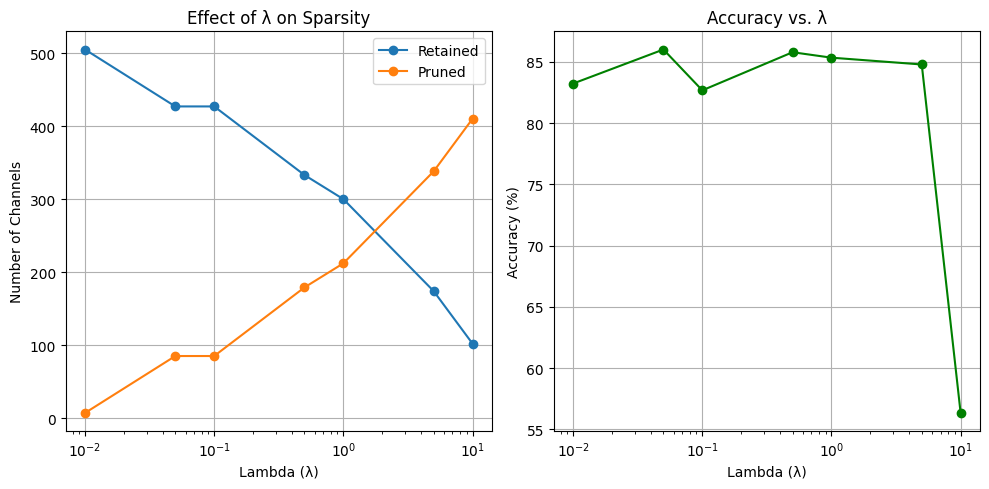

In [ ]:
lambda_sweep = [1e-2, 5e-2, 1e-1, 0.5, 1, 5, 10]
retained_counts = []
accuracy_results = []
for l_val in lambda_sweep:
    model = ChannelSelectionModel(resnet_backbone, C_out, H, W, K).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(total_epochs):
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) + l_val * torch.norm(model.w, 1)
            loss.backward()
            optimizer.step()
    accuracy = evaluate_model(model, testloader)
    retained = torch.sum(torch.abs(model.w.detach()) > pruning_threshold).item()
    retained_counts.append(retained)
    accuracy_results.append(accuracy)
    print(f"Lambda = {l_val:<6}: Accuracy = {accuracy:.2f}%, Retained = {retained}/{C_out}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lambda_sweep, retained_counts, 'o-', label='Retained')
plt.plot(lambda_sweep, [C_out - c for c in retained_counts], 'o-', label='Pruned')
plt.xlabel('Lambda (λ)')
plt.ylabel('Number of Channels')
plt.title('Effect of λ on Sparsity')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambda_sweep, accuracy_results, 'o-', color='green')
plt.xlabel('Lambda (λ)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. λ')
plt.grid(True)
plt.tight_layout()
plt.show()

The plots generated by sweeping the λ show a great result:

- Effect on sparsity: the plot of "retained and pruned channels vs lamda" shows that the number of pruned channels constantly increases. The L1 penalty appears to have effect on the channel count.  
- Effect on accuracy: the "accuracy vs. λ" plot shows a clear results. As lambda increases, the model's accuracy remains constant up to the λ equals 10. Higher values indicate poor accuracy.  

It can be said that a very high sparsity was achieved (75% at a λ equals 5). Probably, this is due to a significant limitation of the initial dataset.

### (c) Display histograms of the learned weights w

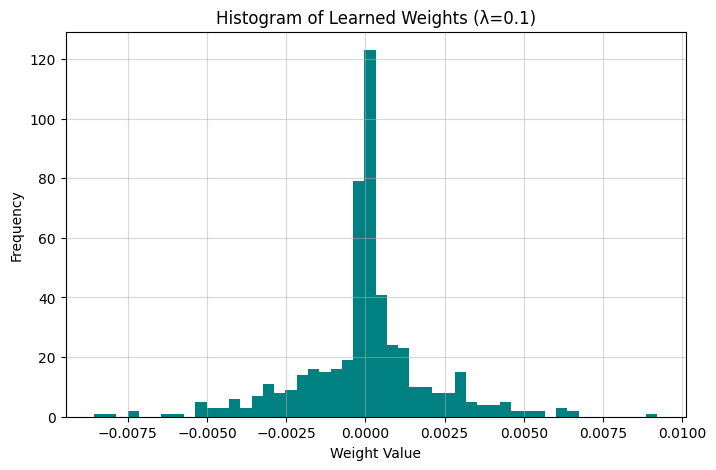

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(final_weights.cpu().numpy(), bins=50, color='teal')
plt.title(f'Histogram of Learned Weights (λ={final_lambda})')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.show()

The histogram of the learned weights w provides visual confirmation of the behavior. We can see the distinct spike at zero which indicate successful pruning.

### (d) Visualize feature maps for retained and pruned channels

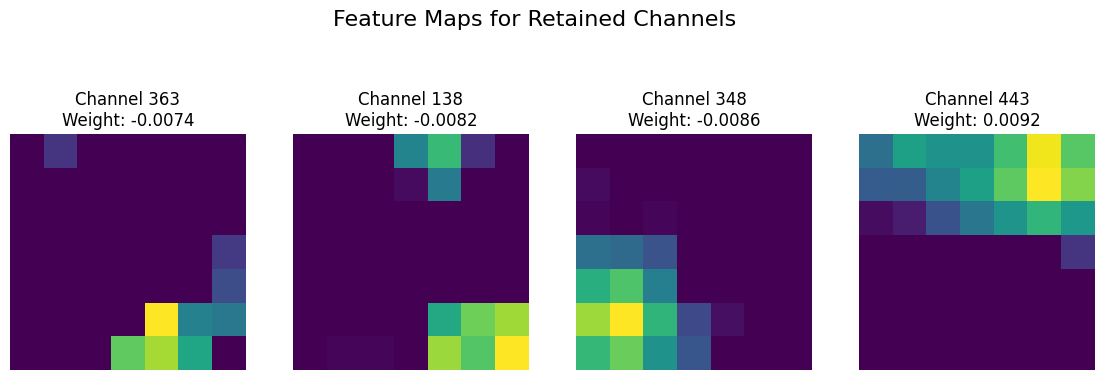

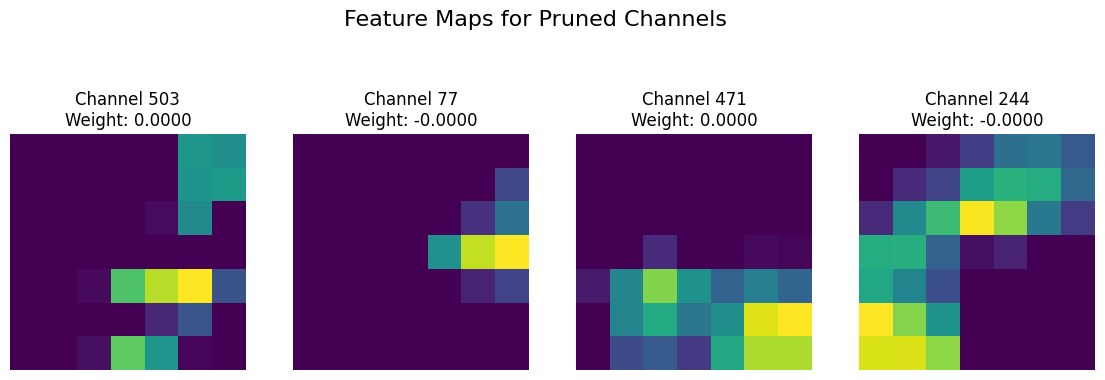

In [ ]:
images, _ = next(iter(testloader))
sample_image = images[0:1].to(device)
with torch.no_grad():
    feature_maps = resnet_backbone(sample_image).cpu().numpy().squeeze()

sorted_indices = torch.argsort(torch.abs(final_weights))
def plot_fmaps(indices, title, weights):
    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    fig.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices):
        axes[i].imshow(feature_maps[idx], cmap='viridis')
        axes[i].set_title(f'Channel {idx.item()}\nWeight: {weights[idx]:.4f}')
        axes[i].axis('off')
    plt.show()
plot_fmaps(sorted_indices[-4:], 'Feature Maps for Retained Channels', final_weights)
plot_fmaps(sorted_indices[:4], 'Feature Maps for Pruned Channels', final_weights)

The visualization shows that there are different kinds of channels. For retained channels, we should see unique examples that play a crucial role in the learning process, while the second row, representing pruned channels, shows non-unique examples.

### Analysis

This experiment demonstrates that L1 regularization is an effective method for channel pruning in deep neural networks.

The L1 penalty forces channel weights (w) to become exactly zero due to the geometry of its constraint space(a hyper-diamond with sharp corners). During optimization, the solution is likely to land on one of these corners, resulting in a sparse model where the corresponding weights are zero. Unlike L2 regularization which only shrinks weights, the L1 penalty acts as a feature selection mechanism, completely eliminating unimportant features.  

The channels that are retained are the ones which are identified as most important for classification. On the other hand, the channels that were pruned were deemed redundant.

By preserving only the core set of discriminative channels, it creates a more efficient model. It maintains a high performance with high sparsity.

# Task 2: Simplex-constrained weights

Now constrain $ w $ to the probability simplex  
$ \Delta_{C_{\text{out}}} = \{ w \geq 0, \mathbf{1}^\top w = 1 \} $.  

Train the model  
$$
\min_{w \in \Delta_{C_{\text{out}}}, F} \frac{1}{B} \sum_{b=1}^B \ell(w^\top X_b F, y_b) + \gamma \|F\|_F^2.
$$

### (a) Projected Gradient

In [ ]:
def simplex_projection(v):
    if v.dim() == 0:
        return v

    n_features = v.shape[0]
    u = torch.sort(v, descending=True)[0]
    cssv = torch.cumsum(u, dim=0)
    rho_candidates = torch.nonzero(u * torch.arange(1, n_features + 1, device=v.device) > (cssv - 1))
    if len(rho_candidates) == 0:
        return torch.zeros_like(v)

    rho = rho_candidates.max()
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return torch.maximum(v - theta, torch.zeros_like(v))

#### Training with simplex-constrained weights

In [ ]:
task2_model = ChannelSelectionModel(resnet_backbone, C_out, H, W, K).to(device)
optimizer = optim.Adam(task2_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(total_epochs):
    task2_model.train()
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = task2_model(inputs)
        loss = criterion(outputs, labels) + gamma_val * torch.norm(task2_model.F, 'fro')**2
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            task2_model.w.data = simplex_projection(task2_model.w.data)

Epoch 1/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/47 [00:00<?, ?it/s]

### Experiments and Analysis

Accuracy with Simplex-Constrained weights: 67.22%
Sum of simplex weights w: 1.0000
Number of weights close to zero (<1e-4): 312; Retained = 200/512

--- Visualizing feature maps for channels with largest and smallest weights values ---


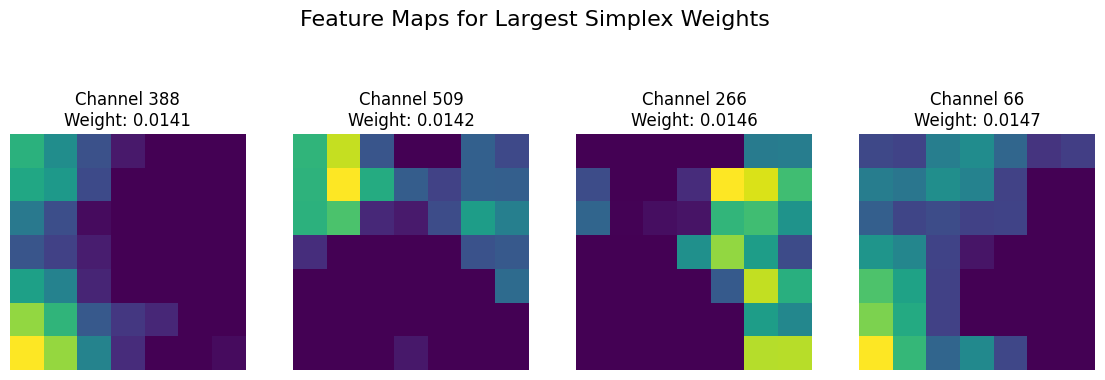

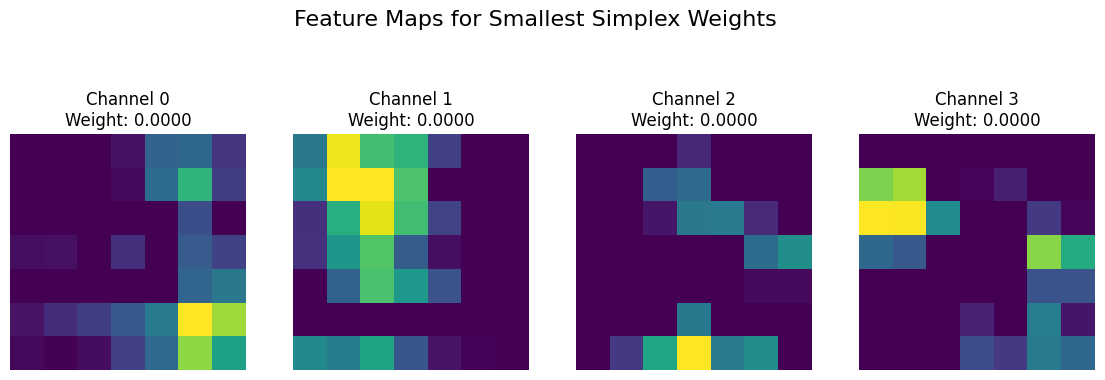

In [ ]:
simplex_accuracy = evaluate_model(task2_model, testloader)
learned_w_simplex = task2_model.w.detach()

print(f"Accuracy with Simplex-Constrained weights: {simplex_accuracy:.2f}%")
print(f"Sum of simplex weights w: {torch.sum(learned_w_simplex).item():.4f}")
pruned = torch.sum(learned_w_simplex < 1e-4).item()
print(f"Number of weights close to zero (<1e-4): {pruned}; Retained = {C_out - pruned}/{C_out}")

print("\n--- Visualizing feature maps for channels with largest and smallest weights values ---")
sorted_indices_simplex = torch.argsort(learned_w_simplex)
plot_fmaps(sorted_indices_simplex[-4:], 'Feature Maps for Largest Simplex Weights', learned_w_simplex.cpu())
plot_fmaps(sorted_indices_simplex[:4], 'Feature Maps for Smallest Simplex Weights', learned_w_simplex.cpu())

After each optimization step, the weight vector w is projected back onto the nearest point on the probability simplex.

This method results a moderate accuracy about 67%, but a degree of sparsity is really high (61%). The reason for this behavior is the "aggressive" dynamic created by the projection. The constraint `Σw = 1` enforces a fixed budget of importance. When a few channels show more value, the gradient update increases their weights. To maintain the sum, the projection step must reduce the value of the other channels. It pushs the weights of less important channels to zero.

Potentialy, this leads the model to a sub-optimal but highly sparse solution, what we are observing.

### (c) Training with softmax parameterization

In [ ]:
class SoftmaxBilinearModel(nn.Module):
    def __init__(self, backbone, C_out, H, W, K, temperature=1.0):
        super().__init__()
        self.backbone = backbone

        self.u = nn.Parameter(torch.randn(C_out) * 0.01)

        self.F = nn.Parameter(torch.randn(H * W, K) * 0.01)
        self.logit_scale = nn.Parameter(torch.ones(1))
        self.tau = temperature

    def forward(self, x):
        with torch.no_grad():
            X = self.backbone(x)

        w = torch.softmax(self.u / self.tau, dim=0)

        X_flat = X.view(X.shape[0], C_out, H * W)
        w_T_X = torch.einsum('c, bci -> bi', w, X_flat)
        scores = torch.matmul(w_T_X, self.F) * self.logit_scale
        return scores

    def get_w(self):
        return torch.softmax(self.u / self.tau, dim=0)

lr = 1e-3
total_epochs = 15
gamma_val = 0.01

temperature_sweep = [0.1, 0.05, 0.01]
for tau_val in temperature_sweep:
    model = SoftmaxBilinearModel(resnet_backbone, C_out, H, W, K, temperature=tau_val).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(total_epochs):
        model.train()
        progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels) + gamma_val * torch.norm(model.F, 'fro')**2

            loss.backward()
            optimizer.step()

    accuracy = evaluate_model(model, testloader)
    final_w = model.get_w().detach()
    num_retained = torch.sum(final_w > 1e-4).item()
    sparsity_pct = (C_out - num_retained) / C_out * 100

    print(f"Tau = {tau_val} Result: Accuracy = {accuracy:.2f}% | Retained = {num_retained}/{C_out} | Sparsity = {sparsity_pct:.2f}%")

Epoch 1/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/47 [00:00<?, ?it/s]

Tau = 0.1 Result: Accuracy = 68.56% | Retained = 207/512 | Sparsity = 59.57%


Epoch 1/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/47 [00:00<?, ?it/s]

Tau = 0.05 Result: Accuracy = 69.44% | Retained = 123/512 | Sparsity = 75.98%


Epoch 1/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/47 [00:00<?, ?it/s]

Tau = 0.01 Result: Accuracy = 68.33% | Retained = 48/512 | Sparsity = 90.62%


In that case, instead of training w directly, we train an unconstrained vector of logits u, and w is defined as softmax(u / τ).  

It is surprising that in this case we do not see a trade-off between sparsity and accuracy. Accuracy for all temperature values is maintained at around 68%, while sparsity increases up to 90%. This is an extremely high value, possibly due to the characteristics of the dataset..  

A low τ "hardens" the softmax, it forces the model to concentrate its predictions onto a small subset of highly important channels, which in turn leads to a sparse w vector.

### Analysis

It provides a comparison between three methods for controlling channel pruning: the L1 penalty, projected gradient, and softmax parameterization.  

Comparison to L1 baseline: The L1 penalty from remains the top performer, achieving the highest accuracy (almost 85%) with big sparsity. The reason is the following: it learns absolute importance and is less constrained.

Simplex methods: both simplex methods learn a relative importance distribution, which is a more challenging and constrained optimization problem.  
Projected gradient performs an aggressive regularizer, forcing a sparse solution at the cost of finding a more accurate local minimum.  
Softmax parameterization leades to a surprising results. It achieves an accuracy about 68% and extremely high level of sparsity (up to 90%). The temperature τ acts as a controller for sparsity level.   

The experiments show that while the L1 penalty is a robust default for pruning, simplex-constrained methods offer a different approach. The softmax parameterization, with a low temperature, can be introduce high level of sparsity. However, it is highly dependent on tuning the temperature hyperparameter. Projected gradiet provides highly sparse sollution as well, but with lower accuracy.

# Task 3: Deep Unrolling (ISTA for Channel Selection)

The LASSO problem  
$$
\min_x \frac{1}{2} \|Ax - b\|_2^2 + \lambda \|x\|_1,
$$  
whose ISTA update is  
$$
x_{k+1} = S_{\lambda/L} \left( x_k - \frac{1}{L} A^\top (Ax_k - b) \right),
$$  
with soft-thresholding operator $ S $ and Lipschitz constant $ L $ of $ A^\top A $.

(a) Reformulation. Fix $ F $ in Task 1 (or precompute $ Z_b = X_b F $). Then the subproblem in $ w $ becomes  
$$
\min_w \frac{1}{2} \|Zw - y\|_2^2 + \lambda \|w\|_1,
$$  
which is a standard LASSO regression.

(b) ISTA layer. Implement the iterative update  
$$
w_{k+1} = S_{\lambda/L} \left( w_k - \frac{1}{L} Z^\top (Z w_k - y) \right),
$$  
and unroll $ T $ iterations as a feed-forward network. Train this unrolled ISTA network end-to-end on the channel selection problem on ResNet-18 features with frozen backbone. Report accuracy, sparsity pattern, and convergence behavior as $ T $ increases.

### (a) Reformulation

In [3]:
Z_list, y_list = [], []
with torch.no_grad():
    for inputs, labels in tqdm(trainloader, desc="Precomputing Z and y"):
        inputs = inputs.to(device)
        X = resnet_backbone(inputs)
        Z_simplified_batch = X.mean(dim=(2, 3)) # B x C_out
        Z_list.append(Z_simplified_batch)
        y_list.append(labels)

Z_simplified = torch.cat(Z_list, dim=0).to(device)
y_simplified = torch.cat(y_list, dim=0).to(device)

ZTZ = torch.matmul(Z_simplified.T, Z_simplified)
ZTy = torch.matmul(Z_simplified.T, y_simplified.float())

Precomputing Z and y:   0%|          | 0/47 [00:00<?, ?it/s]

### (b) ISTA Layer Implementation

In [4]:
def soft_threshold(x, threshold):
    return torch.sign(x) * torch.relu(torch.abs(x) - threshold)

class ISTANet(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.log_lambdas = nn.Parameter(torch.full((T,), -4.0))
        self.log_alphas = nn.Parameter(torch.full((T,), -9.0))

    def forward(self, w, w_grad):
        w_k = w
        for i in range(self.T):
            alpha_k = torch.exp(self.log_alphas[i])
            lambda_k = torch.exp(self.log_lambdas[i])

            w_k = w_k - alpha_k * w_grad
            w_k = soft_threshold(w_k, lambda_k * alpha_k)
        return w_k

for T in [1, 5, 10, 20, 40]:
    main_model = ChannelSelectionModel(resnet_backbone, C_out, H, W, K).to(device)

    ista_net = ISTANet(T=T).to(device)

    optimizer = optim.Adam(list(main_model.parameters()) + list(ista_net.parameters()), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10): # Train for a reasonable number of epochs
        main_model.train()
        ista_net.train()
        progress_bar = tqdm(trainloader, desc=f"T={T}, Epoch {epoch+1}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass to get the data loss gradient
            main_model.w.requires_grad = True

            outputs = main_model(inputs)
            data_loss = criterion(outputs, labels)

            w_grad = torch.autograd.grad(data_loss, main_model.w, retain_graph=True)[0]

            # Unroll ISTA to get the sparse w
            with torch.no_grad():
                w_current = main_model.w.clone()

            w_new = ista_net(w_current, w_grad)

            # Final loss calculation using the sparse w
            main_model.w.data = w_new

            final_outputs = main_model(inputs)
            data_loss = criterion(final_outputs, labels)

            l1_sparsity_loss =  torch.norm(w_new, 1)
            final_loss = data_loss + l1_sparsity_loss

            final_loss.backward()
            optimizer.step()

    main_model.eval()
    accuracy = evaluate_model(main_model, testloader)
    final_w = main_model.w.detach().clone()
    sparsity = (torch.sum(torch.abs(final_w) < 1e-4) / C_out).item()

    print(f"T = {T:2d} | Accuracy: {accuracy:.2f}% | Sparsity: {sparsity*100:.2f}%")

T=1, Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 6:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 7:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 8:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 9:   0%|          | 0/47 [00:00<?, ?it/s]

T=1, Epoch 10:   0%|          | 0/47 [00:00<?, ?it/s]

T =  1 | Accuracy: 84.33% | Sparsity: 1.17%


T=5, Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 6:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 7:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 8:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 9:   0%|          | 0/47 [00:00<?, ?it/s]

T=5, Epoch 10:   0%|          | 0/47 [00:00<?, ?it/s]

T =  5 | Accuracy: 83.56% | Sparsity: 2.15%


T=10, Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 6:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 7:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 8:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 9:   0%|          | 0/47 [00:00<?, ?it/s]

T=10, Epoch 10:   0%|          | 0/47 [00:00<?, ?it/s]

T = 10 | Accuracy: 83.00% | Sparsity: 2.54%


T=20, Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 6:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 7:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 8:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 9:   0%|          | 0/47 [00:00<?, ?it/s]

T=20, Epoch 10:   0%|          | 0/47 [00:00<?, ?it/s]

T = 20 | Accuracy: 85.00% | Sparsity: 4.10%


T=40, Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 6:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 7:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 8:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 9:   0%|          | 0/47 [00:00<?, ?it/s]

T=40, Epoch 10:   0%|          | 0/47 [00:00<?, ?it/s]

T = 40 | Accuracy: 76.67% | Sparsity: 1.17%


### Analysis

The accuracy is generally high, hovering around 83-85%, across different depths <= 20. This proves that the unrolled optimization approach is a valid method for learning a sparse classifier. The model learns to balance the dual objectives of accuracy and sparsity. The dip in accuracy for very high T =40 may be related to an insufficient number of epochs(training might be more difficult or the learned algorithm becomes overly specialized).

As T increases from 1 to 20, the network is able to find solutions that are progressively more sparse while maintaining high accuracy. The drop in sparsity at T=40 shows to the insufficient of training unrolled networks.

In summary, the results show a clear trend where increasing the network's depth (T) allows it to learn a more effective, multi-step sparsification algorithm, leading to higher sparsity in the final channel weights while preserving high classification accuracy. The performance peak at T=20 suggests an optimal trade-off between the algorithm's expressive power and the difficulty of training.

# Task 4: Full-network pruning

Extend channel selection to all convolutional layers. Define global sparsity penalties and evaluate accuracy before and after pruning. Discuss trade-offs between accuracy, sparsity, and interpretability.

In [ ]:
import copy


class PrunableConv2d(nn.Module):
    def __init__(self, conv_layer):
        super().__init__()
        self.conv = conv_layer
        self.w = nn.Parameter(torch.ones(self.conv.out_channels))
        self.pruning_mask = None
    def forward(self, x):
        x = self.conv(x)
        x = x * self.w.view(1, -1, 1, 1)
        if self.pruning_mask is not None:
            x = x * self.pruning_mask.view(1, -1, 1, 1)
        return x

def make_model_prunable(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            setattr(model, name, PrunableConv2d(module))
        elif len(list(module.children())) > 0:
            make_model_prunable(module)

lr_sgd = 1e-3
momentum = 0.9
total_epochs = 15
warmup_epochs = 5
pruning_threshold = 0.1

lambda_sweep = [0.19, 0.195, 0.2]
results = []

for l_val in lambda_sweep:
    prunable_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    prunable_model.fc = nn.Linear(prunable_model.fc.in_features, K)
    make_model_prunable(prunable_model)
    prunable_model = prunable_model.to(device)

    optimizer = optim.SGD(prunable_model.parameters(), lr=lr_sgd, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(total_epochs):
        prunable_model.train()
        current_lambda = 0 if epoch < warmup_epochs else l_val
        desc = f"Epoch {epoch+1} (Warm-up)" if current_lambda == 0 else f"Epoch {epoch+1} (Sparsity λ={l_val})"
        progress_bar = tqdm(trainloader, desc=desc, leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = prunable_model(inputs)
            ce_loss = criterion(outputs, labels)

            global_l1_loss = 0
            for module in prunable_model.modules():
                if isinstance(module, PrunableConv2d):
                    global_l1_loss += torch.norm(module.w, 1)

            loss = ce_loss + current_lambda * global_l1_loss
            loss.backward()
            optimizer.step()

    pruned_model_eval = copy.deepcopy(prunable_model).to(device)
    pruned_model_eval.eval()
    total_channels, pruned_channels = 0, 0
    for module in pruned_model_eval.modules():
        if isinstance(module, PrunableConv2d):
            w_numpy = module.w.detach().cpu().numpy()
            mask = np.abs(w_numpy) > pruning_threshold
            module.pruning_mask = torch.tensor(mask, dtype=torch.float32, device=device)
            total_channels += len(w_numpy)
            pruned_channels += np.sum(mask == 0)

    overall_sparsity = (pruned_channels / total_channels) * 100 if total_channels > 0 else 0
    accuracy_after = evaluate_model(pruned_model_eval, testloader)

    print(f"Result for Lambda = {l_val}: Accuracy = {accuracy_after:.2f}% | Overall Sparsity = {overall_sparsity:.2f}%")

Epoch 1 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15 (Sparsity λ=0.19):   0%|          | 0/47 [00:00<?, ?it/s]

Result for Lambda = 0.19: Accuracy = 77.11% | Overall Sparsity = 0.00%


Epoch 1 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15 (Sparsity λ=0.195):   0%|          | 0/47 [00:00<?, ?it/s]

Result for Lambda = 0.195: Accuracy = 54.11% | Overall Sparsity = 0.00%


Epoch 1 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5 (Warm-up):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15 (Sparsity λ=0.2):   0%|          | 0/47 [00:00<?, ?it/s]

Result for Lambda = 0.2: Accuracy = 33.33% | Overall Sparsity = 100.00%


### Analysis

The results illustrate the extreme trade-off. Below a critical lambda threshold (~0.19), the model prioritizes accuracy, achieving zero sparsity. Just above this threshold (~0.2), it prioritizes sparsity, achieving 100% sparsity but sacrificing all accuracy. 

At lambda=0.19, the model is a "black box" with no sparsity, at lambda=0.2, the model is "white box" and it's doing nothing.    
In this experiment, it was not successful to tune the model. It shows that it requires sensitive tuning. A poorly chosen sparsity penalty can destroy accuracy.

# Task 5: Projection operators

Implement numerical projections onto:
- the probability simplex $ \Delta = \{ x \geq 0, \mathbf{1}^\top x = 1 \} $,
- the positive semidefinite cone $ \mathbb{S}^n_+ $.

Verify the nonexpansiveness property  
$$
\|\Pi_C(y) - \Pi_C(z)\| \leq \|y - z\|, \quad \forall y,z.
$$

### Implement numerical projections

In [ ]:
def projection_probability_simplex(v):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n_features + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return np.maximum(v - theta, 0)

def projection_psd_cone(X):
    X_sym = (X + X.T) / 2
    eigenvalues, eigenvectors = np.linalg.eigh(X_sym)
    clipped_eigenvalues = np.maximum(eigenvalues, 0)
    return eigenvectors @ np.diag(clipped_eigenvalues) @ eigenvectors.T

### Verify the nonexpansiveness property

In [ ]:
np.random.seed(42)

y_simplex = np.random.randn(10)
z_simplex = np.random.randn(10)
proj_y_simplex = projection_probability_simplex(y_simplex)
proj_z_simplex = projection_probability_simplex(z_simplex)
lhs_simplex = np.linalg.norm(proj_y_simplex - proj_z_simplex)
rhs_simplex = np.linalg.norm(y_simplex - z_simplex)
is_nonexpansive_simplex = lhs_simplex <= rhs_simplex
print(f"Result:   {lhs_simplex:.4f} <= {rhs_simplex:.4f}  ->  {is_nonexpansive_simplex}")
print(f"Check sum of projected vector: {np.sum(proj_y_simplex):.4f}")

print("Verifying for positive semidefinite cone")
Y_psd = np.random.randn(5, 5)
Z_psd = np.random.randn(5, 5)
proj_Y_psd = projection_psd_cone(Y_psd)
proj_Z_psd = projection_psd_cone(Z_psd)
lhs_psd = np.linalg.norm(proj_Y_psd - proj_Z_psd)
rhs_psd = np.linalg.norm(Y_psd - Z_psd)
is_nonexpansive_psd = lhs_psd <= rhs_psd
print(f"Result:   {lhs_psd:.4f} <= {rhs_psd:.4f}  ->  {is_nonexpansive_psd}")
print(f"Check eigenvalues of projected matrix: \n{np.linalg.eigvalsh(proj_Y_psd)}")

Result:   1.0021 <= 5.1254  ->  True
Check sum of projected vector: 1.0000
Verifying for positive semidefinite cone
Result:   2.2628 <= 5.6280  ->  True
Check eigenvalues of projected matrix: 
[-1.82966778e-16 -2.09436239e-19  5.19721048e-17  1.23160412e+00
  2.09625026e+00]


### Analysis

Probability simplex verification: the result perfectly demonstrates non-expansiveness. The distance between the two projected vectors is significantly smaller than the distance between the original random vectors, confirming that the projection operation does not move points further apart.  
At the same time, sum of projected vector equals 1. This confirms that the output of the projection function correctly lies on the simplex.  

Positive semidefinite cone verification: this confirms the non-expansiveness property. The distance between the two projected matrices is less than the distance between the original random matrices.  
The eigenvalues of the projected matrix are all non-negative or zero. This proves that the resulting matrix is indeed positive semidefinite.  

The numerical experiments successfully verify that both the probability simplex and the positive semidefinite cone are convex sets whose projection operators are non-expansive.